# Gaussian Mixture Models for Probabilistic Clustering  
### A Case Study on Palmer Penguins

This notebook presents a complete clustering analysis using **Gaussian Mixture Models (GMM)**.  
The aims are:

- To introduce the idea of **probabilistic clustering**.
- To show how GMM can model **overlapping, non-spherical clusters**.
- To compare GMM with **K-Means** on a real dataset.
- To interpret clusters in terms of observable measurements.

The dataset used is the **Palmer Penguins** dataset, which contains body measurements for three penguin species.


## 1. Intuition and Motivation

Many clustering algorithms assign each point to exactly one cluster with no uncertainty.  
In practice, boundaries are often fuzzy: some observations lie between groups and can reasonably belong to more than one.

Gaussian Mixture Models address this by modelling the data as a mixture of several normal distributions.  
Each cluster corresponds to a Gaussian component, and each observation is associated with a **probability distribution over clusters**, not just a hard label.

A useful way to think about this is:

- Each cluster is a “cloud” of points following a multivariate Gaussian pattern.
- Any given point can lie squarely inside one cloud, near the overlap of several clouds, or in a low-density region.
- The model quantifies this as **responsibilities**: the probability that a given point came from each component.


## Mathematical Background

Gaussian Mixture Models assume data are generated from a mixture of \(K\) Gaussian components:

$$
p(x) = \sum_{k=1}^{K} \pi_k \,\mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

where:
- $\pi_k$ are the mixture weights, satisfying $\pi_k \ge 0$ and $\sum_{k=1}^{K} \pi_k = 1$,
- $\mu_k$ are the component means,
- $\Sigma_k$ are the covariance matrices,
- $\mathcal{N}(x \mid \mu_k, \Sigma_k)$ is the Gaussian density for component $k$.

Given data $\{x_1, \dots, x_n\}$, GMM parameters are typically estimated by **Expectation–Maximisation (EM)**:

- **E-step** (responsibilities):

$$
\gamma_{ik} = p(z_i = k \mid x_i) =
\frac{\pi_k \,\mathcal{N}(x_i \mid \mu_k, \Sigma_k)}
{\sum_{j=1}^{K} \pi_j \,\mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
$$

- **M-step**: update $\pi_k, \mu_k, \Sigma_k$ using $\gamma_{ik}$.

This iterative procedure continues until convergence of the log-likelihood.

## 3. Plan

The analysis proceeds in the following order:

1. Load and inspect the Palmer Penguins dataset.
2. Select relevant numeric features and handle missing values.
3. Standardise features to make them comparable in scale.
4. Use the Bayesian Information Criterion (BIC) to select the number of mixture components.
5. Fit a GMM model and obtain cluster assignments and posterior probabilities.
6. Visualise clusters in two-dimensional projections with covariance ellipses.
7. Compare GMM with K-Means on the same feature space.
8. Summarise findings and discuss strengths and limitations of GMM for clustering.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Global plotting settings
plt.style.use("default")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42  # can be replaced with student ID based seed if needed


In [3]:
# Load penguins dataset from seaborn
penguins = sns.load_dataset("penguins")
penguins.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## 4. Data Inspection

The Palmer Penguins dataset includes measurements for different penguin species, including:

- Bill length (mm)
- Bill depth (mm)
- Flipper length (mm)
- Body mass (g)
- Island and sex information

For clustering, only numeric columns will be used.  
The goal is not classification but to see whether an unsupervised model can recover meaningful structure based on body measurements alone.


In [ ]:
penguins.info()
penguins.describe(numeric_only=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


TypeError: NDFrame.describe() got an unexpected keyword argument 'numeric_only'

In [5]:
# Select numeric features
feature_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
data = penguins[feature_cols].copy()

# Drop rows with missing values
data_clean = data.dropna()
print("Original shape:", data.shape)
print("After dropping NA:", data_clean.shape)


Original shape: (344, 4)
After dropping NA: (342, 4)


In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(data_clean)

X[:5]

array([[-0.88449874,  0.78544923, -1.41834665, -0.56414208],
       [-0.81112573,  0.1261879 , -1.06225022, -0.50170305],
       [-0.66437972,  0.43046236, -0.42127665, -1.18853234],
       [-1.32473679,  1.08972369, -0.56371522, -0.93877623],
       [-0.84781224,  1.74898502, -0.77737308, -0.68902013]])

## 5. Exploratory View of the Feature Space

Before fitting any model, it is helpful to inspect pairwise relationships among features.  
Here, a pairplot provides a quick view of how measurements co-vary.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

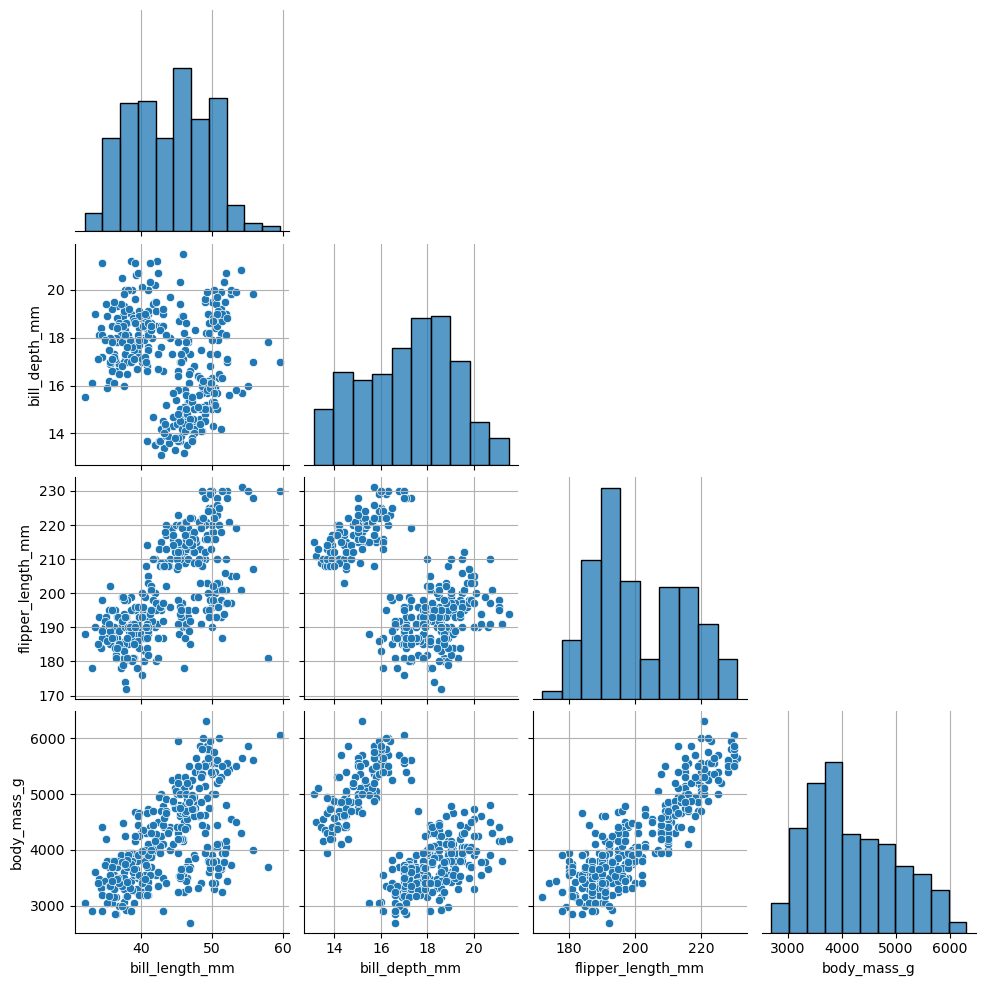

In [7]:
sns.pairplot(
    pd.DataFrame(data_clean, columns=feature_cols),
    corner=True,
    diag_kind="hist"
)
plt.show()


## 6. Selecting the Number of Mixture Components

Gaussian Mixture Models require the number of components \( K \) to be specified.  
To avoid choosing this arbitrarily, several candidate values of \( K \) can be compared using the **Bayesian Information Criterion (BIC)**.

Lower BIC values indicate a better balance between model fit and complexity.


In [8]:
component_range = range(1, 8)
bic_scores = []

for k in component_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=RANDOM_STATE
    )
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

bic_df = pd.DataFrame({"n_components": list(component_range), "BIC": bic_scores})
bic_df


,n_components,BIC
0,1,3117.991906
1,2,2586.798745
2,3,2553.811329
3,4,2613.768389
4,5,2671.996545
5,6,2731.782251
6,7,2802.714159


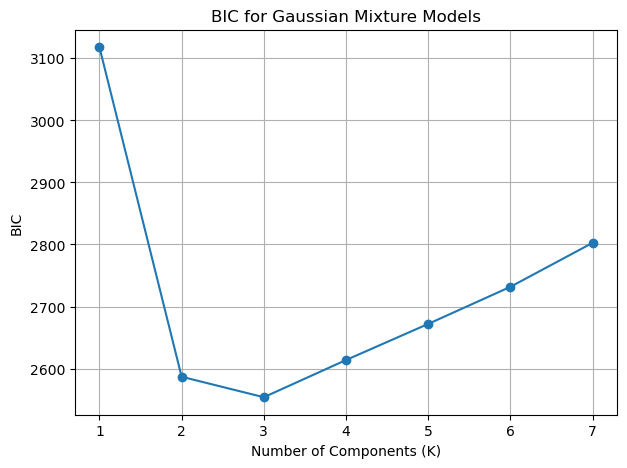

In [9]:
plt.figure()
plt.plot(bic_df["n_components"], bic_df["BIC"], marker="o")
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC")
plt.title("BIC for Gaussian Mixture Models")
plt.xticks(component_range)
plt.show()


The BIC curve typically exhibits a minimum at a preferred value of \( K \).  
Based on the plotted scores, a suitable number of components can be selected.

For the remainder of this analysis, a value of \( K \) at or near the BIC minimum will be used.


In [10]:
# Choose K based on the minimum BIC
best_k = bic_df.loc[bic_df["BIC"].idxmin(), "n_components"]
print("Selected number of components (by BIC):", best_k)

gmm_final = GaussianMixture(
    n_components=int(best_k),
    covariance_type="full",
    random_state=RANDOM_STATE
)
gmm_final.fit(X)

cluster_labels_gmm = gmm_final.predict(X)
proba_gmm = gmm_final.predict_proba(X)

np.unique(cluster_labels_gmm), proba_gmm.shape


Selected number of components (by BIC): 3


(array([0, 1, 2]), (342, 3))

## 7. GMM Clustering Results

To visualise the fitted GMM, two features are selected and plotted with colours indicating cluster membership.  
Additionally, covariance ellipses can be drawn around each component to represent the spread and orientation of each Gaussian.


In [17]:
from matplotlib.patches import Ellipse
import numpy as np

def plot_gaussian_ellipses(gmm, ax, feature_indices=(0, 1), n_std=2.0, **kwargs):
    i, j = feature_indices
    means = gmm.means_[:, [i, j]] if gmm.means_.shape[1] > 2 else gmm.means_
    cov = gmm.covariances_
    if isinstance(cov, np.ndarray) and cov.ndim == 3:
        covs = np.stack([c[np.ix_([i, j], [i, j])] for c in cov], axis=0)
    elif isinstance(cov, np.ndarray) and cov.ndim == 2:
        covs = np.stack([np.diag(c[[i, j]]) for c in cov], axis=0)
    elif isinstance(cov, np.ndarray) and cov.ndim == 1:
        covs = np.stack([np.eye(2) * s for s in cov], axis=0)
    else:
        covs = np.stack([np.asarray(c) for c in cov], axis=0)
    for m, c in zip(means, covs):
        w, v = np.linalg.eigh(c)
        r = w.argsort()[::-1]
        w, v = w[r], v[:, r]
        angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
        width, height = 2 * n_std * np.sqrt(w)
        ax.add_patch(Ellipse(m, width, height, angle, **kwargs))

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

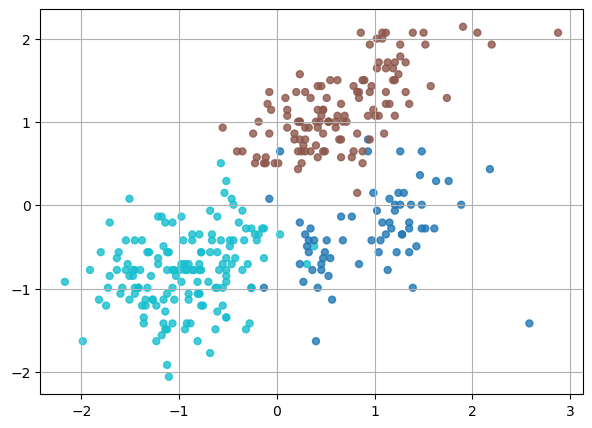

In [21]:
i, j = 0, 2
X_2d = np.asarray(X)[:, [i, j]]

fig, ax = plt.subplots()
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels_gmm, s=25, cmap="tab10", alpha=0.8)

plot_gaussian_ellipses(gmm_final, ax, feature_indices=(i, j), edgecolor="black", linewidth=1.2)

ax.set_xlabel(feature_cols[i] + " (standardised)")
ax.set_ylabel(feature_cols[j] + " (standardised)")
ax.set_title(f"GMM Clusters (K = {int(best_k)})")
plt.show()

### 7.1 Soft Assignments

Gaussian Mixture Models provide, for each observation, a probability distribution over clusters.  
Points near the centre of a component tend to have a single dominant probability, while points in overlapping regions exhibit more balanced responsibilities.

To illustrate this, the maximum posterior probability per point can be examined.


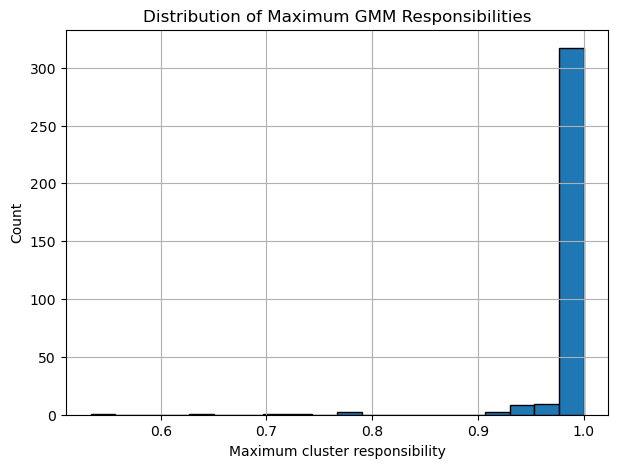

In [19]:
max_resp = proba_gmm.max(axis=1)

plt.figure()
plt.hist(max_resp, bins=20, edgecolor="black")
plt.xlabel("Maximum cluster responsibility")
plt.ylabel("Count")
plt.title("Distribution of Maximum GMM Responsibilities")
plt.show()


## 8. Comparison with K-Means

To provide a point of reference, K-Means clustering is applied with the same number of clusters as the GMM model.  
The comparison highlights differences between:

- Hard assignments vs. soft probabilistic assignments.
- Spherical vs. full covariance cluster shapes.


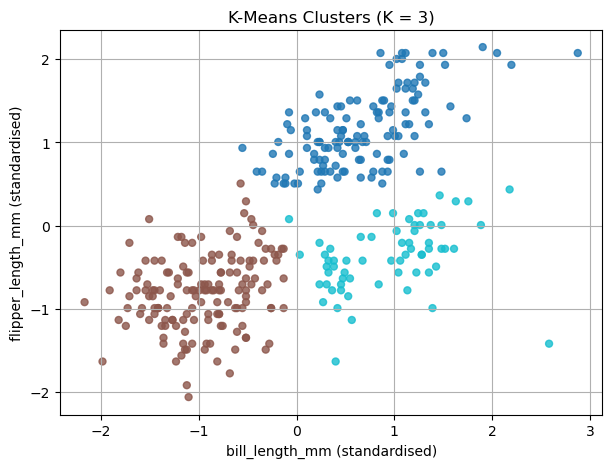

In [20]:
kmeans = KMeans(
    n_clusters=int(best_k),
    random_state=RANDOM_STATE,
    n_init=10
)
kmeans_labels = kmeans.fit_predict(X_2d)

plt.figure()
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=kmeans_labels,
    s=25,
    cmap="tab10",
    alpha=0.8
)
plt.xlabel(feature_cols[i] + " (standardised)")
plt.ylabel(feature_cols[j] + " (standardised)")
plt.title(f"K-Means Clusters (K = {int(best_k)})")
plt.show()


## 9. Summary of Observations

Key observations from the analysis:

- BIC-based model selection yields a reasonable choice of the number of mixture components.
- Gaussian Mixture Models provide flexible cluster shapes through full covariance matrices.
- The model returns soft assignments, allowing interpretation in terms of probabilities rather than hard boundaries.
- In two-dimensional projections, GMM tends to align components with observed clusters in the feature space.
- K-Means enforces equal variance and spherical clusters, which can misrepresent the structure when the data exhibit anisotropic or overlapping patterns.

This notebook forms the computational basis for a written report on probabilistic clustering with Gaussian Mixture Models.
